# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\chait\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

In [8]:
docs =filtered_data['Text']
data = []
for d in docs:
    
    data.append(len(d))

In [9]:
filtered_data['length'] = data

In [10]:
filtered_data.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,416
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,304
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,140
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,131
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,137


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 11)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 11)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:46<00:00, 1883.73it/s]


In [27]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [28]:
# preprocessing for review summary.
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

made in china
Not much taste
hot stuff
Great value


In [29]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

made in china


In [30]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

made in china
Not much taste
hot stuff
Great value


In [31]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [32]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

hot stuff


In [33]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

made in china


In [34]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

hot stuff


In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 37%|███████████████████████████▋                                              | 32774/87773 [00:14<00:23, 2346.16it/s]C:\Users\chait\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▋                      | 61338/87773 [00:26<00:09, 2930.11it/s]C:\Users\chait\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|███████████████████████████████████████████████████████                   | 65366/87773 [00:27<00:08, 2769.88it/s]C:\Users\chait\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

In [37]:
preprocessed_summary[15000]

'good matcha better'

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [38]:
df1 = pd.DataFrame(preprocessed_reviews)

In [39]:
docs =preprocessed_reviews
data = []
for d in docs:
    
    data.append(len(d))

In [40]:
df1['length'] = data

In [41]:
df1.head(20)

,0,length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406
3,worst product gotten long time would rate no s...,209
4,wish would read reviews making purchase basica...,277
5,happy item many flies disturbing kitchen put p...,84
6,thing item trapped fruit flies not work fly tr...,68
7,nurturing plant work well decided repot larger...,495
8,placed around house several days setup fly att...,255
9,please not waste money fly trap absolutely use...,196


In [42]:
df1.columns

Index([0, 'length'], dtype='object')

In [43]:
df1 = df1.rename(columns = {0 : 'preprocessed_reviews'})
df1.head(3)

,preprocessed_reviews,length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [44]:
X=df1[:50000]
PosNeg = final['Score']
y=PosNeg[:50000]


In [45]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score


C:\Users\chait\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [46]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [47]:

print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_tr['preprocessed_reviews'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr['preprocessed_reviews'].values)
X_cv_bow = vectorizer.transform(X_cv['preprocessed_reviews'].values)
X_test_bow = vectorizer.transform(X_test['preprocessed_reviews'].values)

print("After vectorizations")
print(X_train_bow.shape, y_tr.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)


(24500, 2) (24500,)
(10500, 2) (10500,)
(15000, 2) (15000,)
After vectorizations
(24500, 15138) (24500,)
(10500, 15138) (10500,)
(15000, 15138) (15000,)


In [48]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)


After vectorizations
(24500, 1) (24500,)
(10500, 1) (10500,)
(15000, 1) (15000,)


In [49]:
# Feature Engineering
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_bow,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_bow, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_bow, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


Final Data matrix
(24500, 15139) (24500,)
(10500, 15139) (10500,)
(15000, 15139) (15000,)


In [50]:
alpha_values = []
powers = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)    

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]


In [51]:
from sklearn.naive_bayes import MultinomialNB


# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    NB = MultinomialNB(alpha=i)
    NB.fit(X_tr,y_tr)    
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(NB.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha is %d.' % optimal_alpha)




The optimal alpha is 1.


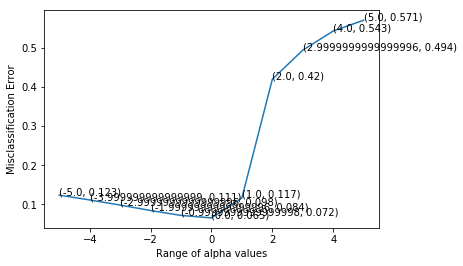

the misclassification error for each alpha value is :  [0.123 0.111 0.098 0.084 0.072 0.065 0.117 0.42  0.494 0.543 0.571]


In [53]:
import math
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of alpha values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [ ]:

# instantiate learning model alpha = optimal_alpha
alpha_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model
alpha_optimal.fit(X_tr, y_tr)

# evaluate AUC
AUC = roc_auc_score(y_test,alpha_optimal.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the NB classifier for alpha = %f is %f%%' % (optimal_alpha, AUC))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
train_auc = []
cv_auc = []

for i in alpha_values:
    NB = MultinomialNB(alpha=i)
    NB.fit(X_tr, y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred = []
    for i in range(0,X_tr.shape[0],1000):
        y_train_pred.extend(NB.predict_proba(X_tr[i:i+1000])[:,1])
        
    
    y_cv_pred =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_pred.extend(NB.predict_proba(X_cv[i:i+1000])[:,1])
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


In [ ]:

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


NB = MultinomialNB(alpha=optimal_alpha)
NB.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], NB.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], NB.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Test confusion matrix")
print(confusion_matrix(y_test, NB.predict(X_test)))

In [ ]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, NB.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.1.1] Top 10 important features of NEGATIVE class from<font color='red'> SET 1</font>

In [54]:
#code copied from https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Naive%20Bayes%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
# using feature_log_prob_ for getting probability scores
features_class = NB.feature_log_prob_
# creating negative and positive classes 
neg = features_class[0]
pos = features_class[1]




In [60]:
neg_sorted

array([ 7569, 14047, 14045, ...,  8120,     0,  6389], dtype=int64)

In [59]:
# using argsort for sorting in descending order
neg_sorted= neg[::-1].argsort()
pos_sorted =pos[::-1].argsort()

features = vectorizer.get_feature_names()
print("TOP 10 IMPORTANT FEATURES OF NEGATIVE CLASS\n\n")
for i in neg_sorted[:10]:
    print("%s    <---------------->     %f"%(features[i],abs(neg[i])))

TOP 10 IMPORTANT FEATURES OF NEGATIVE CLASS


love pop chips    <---------------->     9.625155
twist    <---------------->     9.625125
twinnings    <---------------->     9.625075
insane    <---------------->     9.625105
chicory    <---------------->     9.625135
chicory root    <---------------->     9.625145
ride    <---------------->     9.625135
chihuahuas    <---------------->     9.625135
twin    <---------------->     9.625135
ingredients make    <---------------->     9.625095


### [5.1.2] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [80]:
print("TOP 10 IMPORTANT FEATURES OF POSITIVE CLASS\n\n")
for i in pos_sorted[:10]:
      print("%s      <---------------->     %f"%(features[i],abs(pos[i])))

TOP 10 IMPORTANT FEATURES OF POSITIVE CLASS


happening      <---------------->     11.208871
pay shipping      <---------------->     10.729298
process      <---------------->     8.914008
think      <---------------->     6.436884
able use      <---------------->     11.375925
best popcorn ever      <---------------->     11.134763
might try      <---------------->     11.471235
like said      <---------------->     11.065770
corn chips      <---------------->     10.883449
leash      <---------------->     10.940607


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [92]:
df1 = pd.DataFrame(preprocessed_reviews)

In [93]:
docs =preprocessed_reviews
data = []
for d in docs:
    
    data.append(len(d))

In [94]:
df1['length'] = data

In [95]:
df1.head(20)

,0,length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406
3,worst product gotten long time would rate no s...,209
4,wish would read reviews making purchase basica...,277
5,happy item many flies disturbing kitchen put p...,84
6,thing item trapped fruit flies not work fly tr...,68
7,nurturing plant work well decided repot larger...,495
8,placed around house several days setup fly att...,255
9,please not waste money fly trap absolutely use...,196


In [96]:
df1 = df1.rename(columns = {0 : 'preprocessed_reviews'})
df1.head(3)

,preprocessed_reviews,length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [97]:
X=df1[:50000]
PosNeg = final['Score']
y=PosNeg[:50000]


In [98]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [99]:

print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,dtype=np.float64)
tf_idf_vect.fit(X_tr['preprocessed_reviews'].values)
X_tr_tfidf= tf_idf_vect.transform(X_tr['preprocessed_reviews'].values)
X_cv_tfidf = tf_idf_vect.transform(X_cv['preprocessed_reviews'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['preprocessed_reviews'].values)
print("After vectorizations")
print(X_tr_tfidf.shape, y_tr.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(24500, 2) (24500,)
(10500, 2) (10500,)
(15000, 2) (15000,)
After vectorizations
(24500, 14403) (24500,)
(10500, 14403) (10500,)
(15000, 14403) (15000,)


In [100]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(24500, 1) (24500,)
(10500, 1) (10500,)
(15000, 1) (15000,)


In [101]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_tr_tfidf,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_tfidf, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_tfidf, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


Final Data matrix
(24500, 14404) (24500,)
(10500, 14404) (10500,)
(15000, 14404) (15000,)


In [102]:
alpha_values = []
powers = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)    

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]


In [103]:
from sklearn.naive_bayes import MultinomialNB


# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    NB = MultinomialNB(alpha=i)
    NB.fit(X_tr,y_tr)    
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(NB.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())
print(AUC_scores)
# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha is %f.' % optimal_alpha)


[0.8894748542559721, 0.9025417287230855, 0.9165509883027905, 0.9297429741334098, 0.9388959179890664, 0.9340755491896848, 0.8288390194294801, 0.6863171612559628, 0.6332509990333155, 0.6183353012656865, 0.6163671234648338]

The optimal alpha is 0.100000.


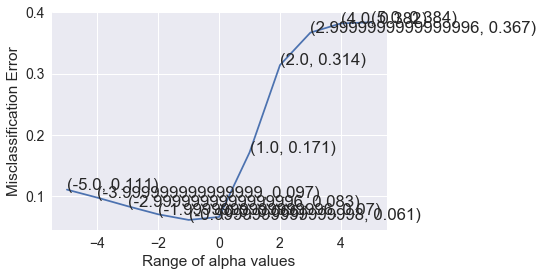

the misclassification error for each alpha value is :  [0.111 0.097 0.083 0.07  0.061 0.066 0.171 0.314 0.367 0.382 0.384]


In [105]:
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of alpha values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [106]:

# instantiate learning model alpha = optimal_alpha
alpha_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model
alpha_optimal.fit(X_tr, y_tr)

# evaluate AUC
AUC = roc_auc_score(y_test,alpha_optimal.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the NB classifier for alpha = %f is %f%%' % (optimal_alpha, AUC))


The AUC of the NB classifier for alpha = 0.100000 is 94.037858%


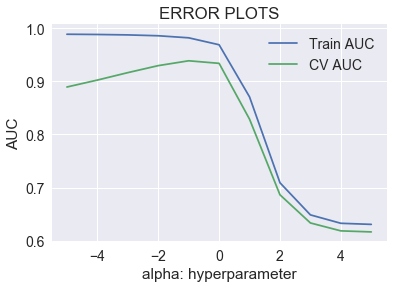

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
train_auc = []
cv_auc = []

for i in alpha_values:
    NB = MultinomialNB(alpha=i)
    NB.fit(X_tr, y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred = []
    for i in range(0,X_tr.shape[0],1000):
        y_train_pred.extend(NB.predict_proba(X_tr[i:i+1000])[:,1])
        
    
    y_cv_pred =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_pred.extend(NB.predict_proba(X_cv[i:i+1000])[:,1])
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


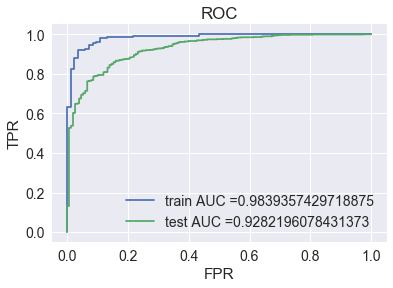

Test confusion matrix
[[  949  1432]
 [  116 12503]]


In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


NB = MultinomialNB(alpha=optimal_alpha)
NB.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], NB.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], NB.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Test confusion matrix")
print(confusion_matrix(y_test, NB.predict(X_test)))

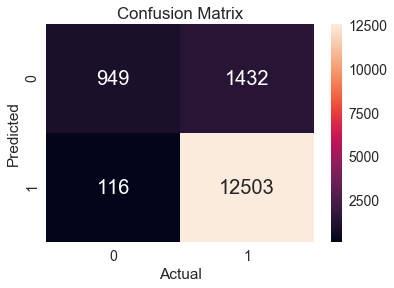

In [109]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, NB.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [110]:
# code copied from --https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Naive%20Bayes%20on%20Amazon%20Fine%20Food%20Reviews.ipynb
# using feature_log_prob_ for getting probability scores
features_class = NB.feature_log_prob_
# creating negative and positive classes 
neg = features_class[0]
pos = features_class[1]

features = tf_idf_vect.get_feature_names()

# using argsort for sorting in descending order
neg_sorted= neg[::-1].argsort()
pos_sorted =pos[::-1].argsort()


In [111]:
print("TOP 10 IMPORTANT FEATURES OF POSITIVE CLASS\n\n")
for i in pos_sorted[:10]:
      print("%s      <---------------->     %f"%(features[i],abs(pos[i])))

TOP 10 IMPORTANT FEATURES OF POSITIVE CLASS


received tea      <---------------->     10.638818
pastas      <---------------->     9.472417
really glad      <---------------->     10.743821
probably not      <---------------->     9.537539
best dog      <---------------->     10.545954
usually order      <---------------->     11.226683
content      <---------------->     8.412140
stash teas      <---------------->     11.143931
er      <---------------->     11.353566
much flavor      <---------------->     10.214044


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [112]:
# using argsort for sorting in descending order
neg_sorted= neg[::-1].argsort()
pos_sorted =pos[::-1].argsort()

print("TOP 10 IMPORTANT FEATURES OF NEGATIVE CLASS\n\n")
for i in neg_sorted[:10]:
    print("%s    <---------------->     %f"%(features[i],abs(neg[i])))

TOP 10 IMPORTANT FEATURES OF NEGATIVE CLASS


love flavors    <---------------->     10.156563
shipping fast    <---------------->     10.757628
earthy    <---------------->     10.089860
easier eat    <---------------->     12.469118
easily get    <---------------->     10.866587
easily make    <---------------->     11.425094
easy    <---------------->     8.488531
ship    <---------------->     8.369368
shelf life    <---------------->     9.627420
shedding    <---------------->     11.928304


# [6] Conclusions

In [113]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
PTable = PrettyTable()
PTable.field_names = ["Vectorizor", "Hyperparameter", "Train-AUC","Test-AUC"]

In [114]:
PTable.add_row(['BoW',1,0.98,0.92])

PTable.add_row(['TF-IDF',0.1,0.98,0.93])
print(PTable)



+------------+----------------+-----------+----------+
| Vectorizor | Hyperparameter | Train-AUC | Test-AUC |
+------------+----------------+-----------+----------+
|    BoW     |       1        |    0.98   |   0.92   |
|   TF-IDF   |      0.1       |    0.98   |   0.93   |
+------------+----------------+-----------+----------+


# Summary

1. First I loaded the data from SQLite Database.

2. Data Cleaning: 
Deduplication - duplicates are removed

3. Preprocessing: 
It is done to remove html tags, punctuations or limited set of special characters ,Stopwords etc.
Preprocessing is performed on review text and summary text.





# Applying Multinomial Naive Bayes

1. In this analysis Multinomial Naive Bayes is applied on Bag of Words and TF-IDF vectorizers.
2. Firstly I created new dataframe (df1), where i used only preprocessed review text as a seperate column.
3. For each reviews I created a new feature - length(which computes length of review text).
4. Then I created a new column for length feature in the dataframe.
5. Considering only 100k data points I spllited the data into 3 parts -Train,Cv,Test.
6. Using BoW's - countvectorizer, I fitted Train data first and transformed it.
7. Simillarly Cv and test data is transformed.
8. Length column is Normalized(normalizer() is used to normalize each non zero feature).
9. Then the preprocessed reviews along with their lengths are merged into a sparse matrix using hstack.
10. hstack is used to merge two matrices horizontally.
11. For finding best alpha(Hyperparameter) - I created a list of different alpha values ranging from 10^-5 to 10^5.
12. Using for loop I did hyperparameter tuning.
13. Crossvalidation data is used to find the best hyperparameter
14. I used Miss-Classification error to find best alpha (1-MSE) gives best AUC(Used AUC metric for finding best alpha).
15. Then I plotted Error plot and Roc plot.
16. For both Bow and TF-IDF I splitted the data into positive class and negative class.
17. feature_log_prob_ is used to get the estimated log probability of the features for each class.
18. get_feature_names() is used to get the feature names.
19. argsort() for sorting in descending order. argsort() gives the indices of every feature.
20. Finally printed top 10 feature names along with absolute log probabilities.
